### Dataset: https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset?resource=download
### Tutorial: https://www.youtube.com/watch?v=V_xro1bcAuA&t=77134s

In [107]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [117]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
torch.__version__

'2.2.1+cu121'

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [110]:
!nvidia-smi

Tue Mar 12 22:26:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 41%   43C    P8             34W /  400W |     848MiB /  12288MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [111]:
IMAGE_PATH = "./data/melanoma"

In [112]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filesnames)} images in '{dirpath}'")

walk_through_dir("./data")

There are 1 directories and 0 images in './data'
There are 2 directories and 0 images in './data/melanoma'
There are 2 directories and 0 images in './data/melanoma/train'
There are 0 directories and 100 images in './data/melanoma/train/Benign'
There are 0 directories and 100 images in './data/melanoma/train/Malignant'
There are 2 directories and 0 images in './data/melanoma/test'
There are 0 directories and 100 images in './data/melanoma/test/Benign'
There are 0 directories and 100 images in './data/melanoma/test/Malignant'


In [113]:
image_dir = Path("./data/melanoma")

Random image path: data/melanoma/train/Malignant/409.jpg
Image class is: Malignant
Image width: 224
Image height: 224


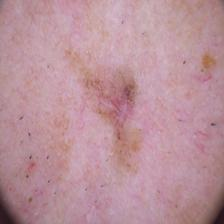

In [114]:
image_path_list = list(image_dir.glob("*/*/*.jpg"))
rand_image_path = random.choice(image_path_list)
image_class = rand_image_path.parent.stem
img = Image.open(rand_image_path)
print(f"Random image path: {rand_image_path}")
print(f"Image class is: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

(-0.5, 223.5, 223.5, -0.5)

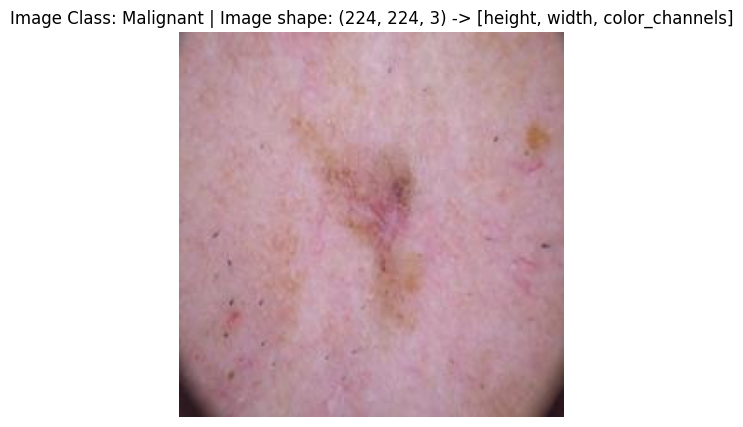

In [115]:
img_as_array = np.asarray(img)

plt.figure(figsize=(5,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [116]:
img_as_array

array([[[124, 103, 110],
        [128, 107, 114],
        [137, 111, 120],
        ...,
        [128, 100,  99],
        [123,  94,  96],
        [117,  91,  92]],

       [[129, 108, 115],
        [133, 110, 118],
        [140, 114, 123],
        ...,
        [132, 104, 103],
        [127,  98, 100],
        [121,  95,  96]],

       [[133, 110, 118],
        [136, 113, 121],
        [142, 116, 125],
        ...,
        [137, 109, 108],
        [131, 102, 104],
        [125,  99, 100]],

       ...,

       [[ 52,  29,  37],
        [ 51,  28,  36],
        [ 49,  28,  35],
        ...,
        [ 43,  24,  30],
        [ 45,  24,  29],
        [ 45,  24,  29]],

       [[ 53,  30,  38],
        [ 52,  29,  37],
        [ 49,  28,  35],
        ...,
        [ 43,  24,  30],
        [ 45,  24,  29],
        [ 48,  26,  29]],

       [[ 53,  30,  38],
        [ 52,  29,  37],
        [ 50,  29,  36],
        ...,
        [ 42,  23,  27],
        [ 47,  24,  30],
        [ 49,  27,  30]]

In [119]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [122]:
data_transform(img).dtype

torch.float32

In [ ]:
def plot_transformed_images(image_paths, transform, n=3):
    